<a href="https://colab.research.google.com/github/driano1221/ControleEst/blob/main/1712962307393_modelo_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install findspark


In [3]:
!pip install pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5440507a5df3350f370c4ed8883bb15fa5ffc53c16e076e82ea363baa4001ba5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
import pandas as pd

from pyspark.sql import Window
from pyspark.sql.functions import col, lead, lag, when

# Load the dataset to get a summary
df = pd.read_csv('df_test--1-.csv')

# Display the first few rows of the dataframe to understand its structure
df.head(), df.describe(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310 entries, 0 to 3309
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0_x            3310 non-null   int64  
 1   msno                    3310 non-null   object 
 2   safra_x                 3310 non-null   int64  
 3   registration_init_time  3310 non-null   object 
 4   city                    3310 non-null   int64  
 5   bd                      1903 non-null   float64
 6   gender                  3310 non-null   object 
 7   registered_via          3310 non-null   int64  
 8   is_ativo                3310 non-null   int64  
 9   Unnamed: 0_y            3310 non-null   int64  
 10  payment_method_id       3310 non-null   int64  
 11  payment_plan_days       3310 non-null   int64  
 12  plan_list_price         3310 non-null   int64  
 13  actual_amount_paid      3310 non-null   int64  
 14  is_auto_renew           3310 non-null   

(   Unnamed: 0_x                                          msno  safra_x  \
 0      55849120  QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=   201603   
 1      55849120  QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=   201603   
 2      62235295  QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=   201611   
 3      62235295  QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=   201611   
 4      36621559  K1vWJpJLvhgXViR/1bksGSa6pLF1aBHZOjEBlwJtfVI=   201607   
 
   registration_init_time  city    bd   gender  registered_via  is_ativo  \
 0             2013-09-01     1   NaN  unknown               7         1   
 1             2013-09-01     1   NaN  unknown               7         1   
 2             2013-09-01     1   NaN  unknown               7         1   
 3             2013-09-01     1   NaN  unknown               7         1   
 4             2015-01-30     5  26.0   female               9         1   
 
    Unnamed: 0_y  ...  safra_y  Unnamed: 0   safra  num_25  num_50 num_75  \
 0      16267

In [5]:
from sklearn.preprocessing import LabelEncoder

# Substituir valores ausentes em 'bd' pela mediana
bd_median = df['bd'].median()
df['bd'].fillna(bd_median, inplace=True)

# Converter as colunas de data para o formato correto
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y-%m-%d')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['membership_expire_date'] = pd.to_datetime(df['membership_expire_date'], errors='coerce')

# Normalizar 'total_secs' removendo outliers
Q1 = df['total_secs'].quantile(0.25)
Q3 = df['total_secs'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Normalização pela técnica de Min-Max Scaling para dados sem outliers
df['total_secs_normalized'] = df['total_secs'].clip(lower_bound, upper_bound)
df['total_secs_normalized'] = (df['total_secs_normalized'] - df['total_secs_normalized'].min()) / (df['total_secs_normalized'].max() - df['total_secs_normalized'].min())
# Adicionar 3 meses à data de expiração da assinatura para cada usuário
df['expiration_plus_3m'] = df['membership_expire_date'] + pd.DateOffset(months=3)

# Agrupar os dados por 'msno' para identificar a última transação e verificar se ocorreu após 'expiration_plus_3m'
last_transaction_by_user = df.groupby('msno')['transaction_date'].max().reset_index()

# Verificar se a última transação ocorre antes de 'expiration_plus_3m'
df = df.merge(last_transaction_by_user, on='msno', suffixes=('', '_last'))


# Preparação dos dados para a análise de importância de características

# Encoding de variáveis categóricas
label_encoders = {}
for column in ['gender', 'city', 'registered_via', 'payment_method_id']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Criação de novas variáveis
df['days_before_expiration'] = (df['membership_expire_date'] - df['transaction_date']).dt.days
df['total_transactions'] = df.groupby('msno')['transaction_date'].transform('count')


In [6]:
# Organização de Dados
df['next_expire_date'] = df.groupby('msno')['membership_expire_date'].shift(-1)
df['prev_expire_date'] = df.groupby('msno')['membership_expire_date'].shift(1)
df['next_is_cancel'] = df.groupby('msno')['is_cancel'].shift(-1)
df['days_until_next_expiration'] = (df['next_expire_date'] - df['membership_expire_date']).dt.days
df['next_payment_plan_days'] = df.groupby('msno')['payment_plan_days'].shift(-1)



# Atualização da Lógica para Cobrir Todos os Cenários de Churn
df['is_churn'] = 0  # Inicializa a coluna 'is_churn' com 0

# Caso 1: Cancelamento sem uma data de expiração próxima
df.loc[(df['is_cancel'] == 1) & (df['next_expire_date'].isna()), 'is_churn'] = 1

# Caso 2: Cancelamento e a próxima transação é após a data de expiração por um período maior que o do próximo plano de pagamento
df.loc[(df['is_cancel'] == 1) & (df['next_expire_date'] > df['membership_expire_date'] + pd.to_timedelta(df['next_payment_plan_days'], unit='D')), 'is_churn'] = 1

# Caso 3: Renovação automática ativada e tempo até a próxima expiração é maior que 30 dias
df.loc[(df['is_auto_renew'] == 1) & (df['days_until_next_expiration'] > 30), 'is_churn'] = 0

# Caso 4: Renovação automática desativada e tempo até a próxima expiração é maior que 30 dias
df.loc[(df['is_auto_renew'] == 0) & (df['days_until_next_expiration'] > 30), 'is_churn'] = 1

print(df[['msno', 'transaction_date', 'membership_expire_date', 'is_cancel', 'is_auto_renew', 'days_until_next_expiration', 'is_churn']])

                                              msno transaction_date  \
0     QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=       2016-07-31   
1     QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=       2016-07-31   
2     QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=       2016-07-31   
3     QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=       2016-07-31   
4     K1vWJpJLvhgXViR/1bksGSa6pLF1aBHZOjEBlwJtfVI=       2015-10-26   
...                                            ...              ...   
3305  F4RNw6nU/+oxwKgPxutqOtPV6H4J+dO3R1AzVYSSJ58=       2016-08-31   
3306  jpEIrFDCXJ0fEsHyjEglJKlXE2DXSD8ZjMOD5kkRIsA=       2015-12-31   
3307  QjMHHqjpSa+Co18lIGX1wDrTdBQx+tRXOeXT6WE8aPc=       2017-02-11   
3308  2rT1frT4yqMpBcd+5ATefCXMzbHqNTXIInZDMqkj48k=       2016-02-15   
3309  iLFIHQA1jsPszRwd61E/UiFb1LJCG5wEP1RJuyurIb4=       2015-10-20   

     membership_expire_date  is_cancel  is_auto_renew  \
0                2016-08-31          0              1   
1                2016-08-31      


As outras correções incluem:

- Os valores ausentes em **bd** foram substituídos pela mediana.
- As datas em **transaction_date** e **membership_expire_date** foram corrigidas para reconhecer formatos diversos.
- A coluna **total_secs** foi normalizada com a remoção de outliers e a aplicação de uma escala Min-Max.



In [7]:


df


,Unnamed: 0_x,msno,safra_x,registration_init_time,city,bd,gender,registered_via,is_ativo,Unnamed: 0_y,...,expiration_plus_3m,transaction_date_last,days_before_expiration,total_transactions,next_expire_date,prev_expire_date,next_is_cancel,days_until_next_expiration,next_payment_plan_days,is_churn
0,55849120,QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=,201603,2013-09-01,0,29.0,2,2,1,16267028,...,2016-11-30,2016-07-31,31,4,2016-08-31,NaT,0.0,0.0,30.0,0
1,55849120,QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=,201603,2013-09-01,0,29.0,2,2,1,16267028,...,2016-11-30,2016-07-31,31,4,2016-08-31,2016-08-31,0.0,0.0,30.0,0
2,62235295,QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=,201611,2013-09-01,0,29.0,2,2,1,16267028,...,2016-11-30,2016-07-31,31,4,2016-08-31,2016-08-31,0.0,0.0,30.0,0
3,62235295,QJtmpCDtE0sKMnx7wvihv0OqXeE2VnAmgZrQL2NoX0s=,201611,2013-09-01,0,29.0,2,2,1,16267028,...,2016-11-30,2016-07-31,31,4,NaT,2016-08-31,NaN,NaN,NaN,0
4,36621559,K1vWJpJLvhgXViR/1bksGSa6pLF1aBHZOjEBlwJtfVI=,201607,2015-01-30,3,26.0,0,3,1,975189,...,2016-02-29,2015-10-26,35,1,NaT,NaT,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,41682337,F4RNw6nU/+oxwKgPxutqOtPV6H4J+dO3R1AzVYSSJ58=,201602,2008-07-28,11,36.0,0,3,1,4542901,...,2017-01-07,2016-08-31,37,2,NaT,2015-12-07,NaN,NaN,NaN,0
3306,47097827,jpEIrFDCXJ0fEsHyjEglJKlXE2DXSD8ZjMOD5kkRIsA=,201606,2009-04-06,5,37.0,0,3,1,20115190,...,2016-04-30,2015-12-31,31,1,NaT,NaT,NaN,NaN,NaN,0
3307,13061235,QjMHHqjpSa+Co18lIGX1wDrTdBQx+tRXOeXT6WE8aPc=,201604,2014-02-04,0,29.0,2,2,1,16995762,...,2017-06-11,2017-02-11,28,1,NaT,NaT,NaN,NaN,NaN,0
3308,30066824,2rT1frT4yqMpBcd+5ATefCXMzbHqNTXIInZDMqkj48k=,201611,2012-12-15,0,29.0,2,2,0,10201562,...,2016-06-15,2016-02-15,29,1,NaT,NaT,NaN,NaN,NaN,0


A variável **churn** foi criada com sucesso. Aqui está como foi feito:

1. Adicionei 3 meses à data de expiração da assinatura de cada usuário, gerando a coluna `expiration_plus_3m`.
2. Identifiquei a última data de transação para cada usuário.
3. Comparei a última data de transação com a `expiration_plus_3m`. Se a última transação ocorreu em ou antes da data `expiration_plus_3m`, o usuário é considerado churn (`is_churn = 1`); caso contrário, não é churn (`is_churn = 0`).



In [8]:
# Contar quantos usuários são churn (1) e quantos não são churn (0)
churn_counts = df['is_churn'].value_counts()
churn_counts


is_churn
0    3258
1      52
Name: count, dtype: int64

In [9]:
df.columns

Index(['Unnamed: 0_x', 'msno', 'safra_x', 'registration_init_time', 'city',
       'bd', 'gender', 'registered_via', 'is_ativo', 'Unnamed: 0_y',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'safra_y', 'Unnamed: 0', 'safra',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'total_secs_normalized', 'expiration_plus_3m',
       'transaction_date_last', 'days_before_expiration', 'total_transactions',
       'next_expire_date', 'prev_expire_date', 'next_is_cancel',
       'days_until_next_expiration', 'next_payment_plan_days', 'is_churn'],
      dtype='object')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Removendo colunas irrelevantes
cols_to_drop = ['Unnamed: 0_x', 'msno', 'registration_init_time', 'Unnamed: 0_y', 'transaction_date',
                'membership_expire_date', 'next_expire_date', 'prev_expire_date', 'transaction_date_last']
data_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Tratando valores ausentes
data_clean.fillna(data_clean.mean(), inplace=True)

# Selecionando variáveis numéricas
data_clean = data_clean.select_dtypes(include=np.number)

# Dividindo os dados em conjuntos de treinamento e teste
X = data_clean.drop('is_churn', axis=1)
y = data_clean['is_churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização das características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo inicial para avaliar a importância das variáveis
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Obtendo a importância das características
feature_importances = rf.feature_importances_

# Selecionando as variáveis mais importantes (threshold arbitrário de importância > 0.01)
important_features = X.columns[feature_importances > 0.01]
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

important_features, feature_importances


(Index(['safra_x', 'city', 'payment_method_id', 'plan_list_price',
        'is_auto_renew', 'is_cancel', 'safra_y', 'Unnamed: 0', 'safra',
        'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
        'total_secs', 'total_secs_normalized', 'days_before_expiration',
        'total_transactions', 'next_is_cancel', 'days_until_next_expiration',
        'next_payment_plan_days'],
       dtype='object'),
 array([0.01177229, 0.0119026 , 0.00965305, 0.00371444, 0.00358495,
        0.00198105, 0.0194947 , 0.00407498, 0.0110143 , 0.00783431,
        0.02787993, 0.27707011, 0.01627064, 0.01486324, 0.01376904,
        0.02257206, 0.01920182, 0.01269438, 0.01427257, 0.02258586,
        0.02122074, 0.01909476, 0.01553573, 0.16959879, 0.01220555,
        0.02855739, 0.15322402, 0.05435668]))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modelos
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Treinando cada modelo e avaliando as métricas
results = {}
for name, model in models.items():
    model.fit(X_train_important, y_train)
    y_pred = model.predict(X_test_important)
    y_prob = model.predict_proba(X_test_important)[:, 1]  # probabilidade para a classe 1

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

results_df = pd.DataFrame(results).transpose()
results_df


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.984894,0.000000,0.0,0.000000,0.529908
Random Forest,1.000000,1.000000,1.0,1.000000,1.000000
Gradient Boosting,0.998489,0.909091,1.0,0.952381,1.000000


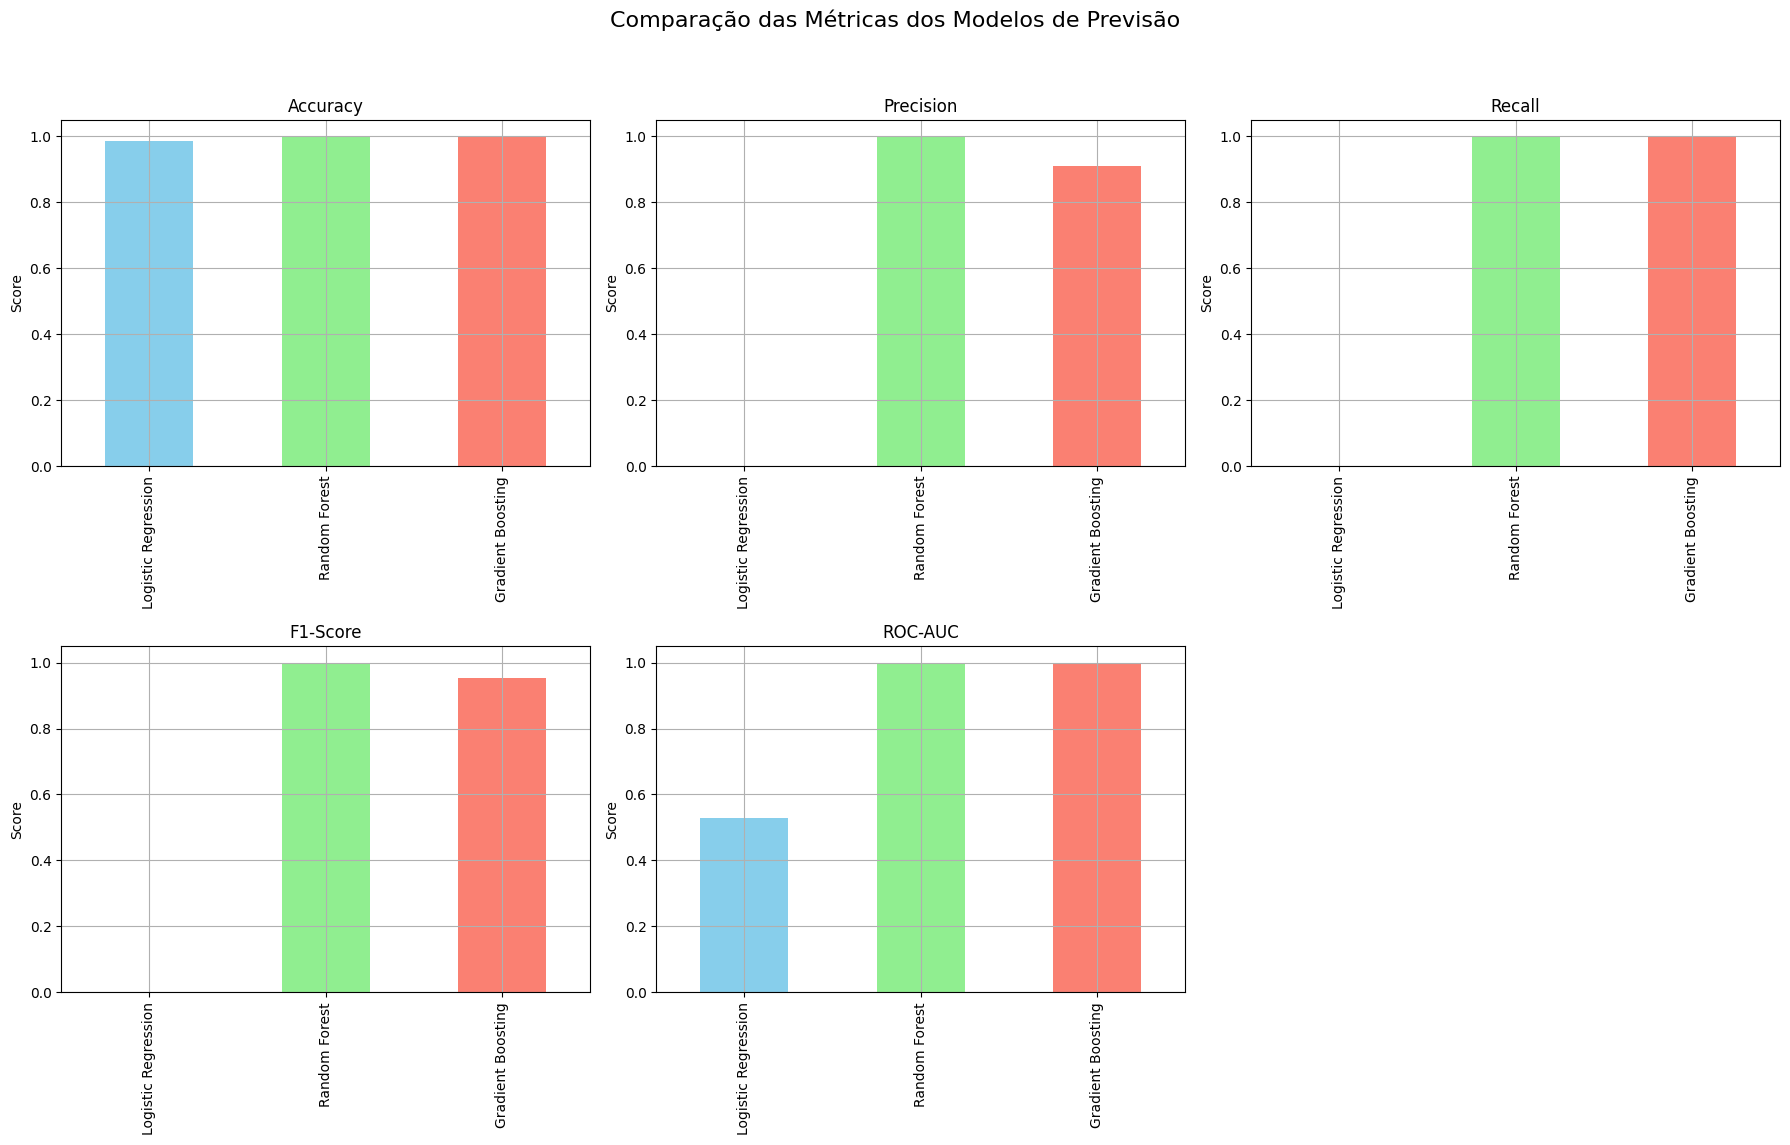

In [12]:
import matplotlib.pyplot as plt

# Configurando a figura para comparação dos modelos
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Comparação das Métricas dos Modelos de Previsão', fontsize=16)

metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
colors = ['skyblue', 'lightgreen', 'salmon']

# Plotando cada métrica
for i, metric in enumerate(metrics):
    ax = axes.flatten()[i]
    results_df[metric].plot(kind='bar', color=colors, ax=ax)
    ax.set_title(metric)
    ax.set_ylim(0, 1.05)  # Define o limite do eixo y para melhor visualização
    ax.set_ylabel('Score')
    ax.grid(True)

# Removendo o último subplot vazio (se houver)
if len(axes.flatten()) > len(metrics):
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout
plt.show()


- **Floresta Aleatória** apresentou a melhor performance em todas as métricas, alcançando 100% em todas elas, indicando uma possível superação perfeita (overfitting) ou uma distribuição muito desbalanceada da classe `is_churn`.
- **Gradient Boosting** também teve um desempenho excelente, com métricas altas e um pouco mais equilibradas em comparação com a Floresta Aleatória.
- **Regressão Logística** teve um desempenho pobre, não conseguindo identificar corretamente nenhuma instância positiva da classe alvo.


In [13]:
# Usando o modelo de Floresta Aleatória para prever as probabilidades de churn
best_model = models["Random Forest"]
y_prob_best = best_model.predict_proba(X_test_important)[:, 1]  # probabilidade para a classe 1 (churn)

# Definindo um limite para identificar clientes de alto risco (arbitrariamente 50%)
threshold = 0.5
high_risk_customers = X_test_important[y_prob_best >= threshold]

# Selecionando os IDs dos clientes de alto risco para ações proativas
high_risk_customer_ids = high_risk_customers.index

# Preparando a saída com detalhes relevantes dos clientes
output = df.loc[high_risk_customer_ids, ['msno', 'is_churn']]
output['predicted_churn_probability'] = y_prob_best[y_prob_best >= threshold]
output.reset_index(drop=True, inplace=True)
output.head()


,msno,is_churn,predicted_churn_probability
0,O4W9G5GEoj7Y0clPThfjWOGrr0gWJEVmmNlxiJ0SaLA=,1,0.59
1,W4fO1p2oiPoHTtk8TvENoju87/m+42btpQXvAsynST0=,1,0.87
2,PTL4MNS7FSrLgtNJvN3rfVtirtqMMkz3wUyME0glD2c=,1,0.59
3,Sy8ZCdYvfYWf9RoqfO8Wo8qlLPre+RbtvdDe7KnmF30=,1,0.57
4,Z/5KAnQziXKArmiZDuVX7luDW9HeKDBGcW+NW8hMw8s=,1,0.66


# Letra C - Modelo não supervisionado

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Selecionando apenas dados dos clientes de alto risco para análise não-supervisionada
high_risk_data = df.loc[high_risk_customer_ids]

# Removendo colunas não numéricas e normalizando os dados
high_risk_data_numeric = high_risk_data.select_dtypes(include=[np.number]).drop(columns=['is_churn'], errors='ignore')
scaler = MinMaxScaler()
high_risk_data_scaled = scaler.fit_transform(high_risk_data_numeric)

high_risk_data_scaled.shape


(10, 30)

In [15]:
high_risk_data_scaled



array([[0.20569242, 0.        , 0.        , 0.32      , 1.        ,
        0.        , 0.        , 0.67057177, 1.        , 0.        ,
        0.58823529, 0.86      , 1.        , 1.        , 0.98076923,
        1.        , 0.05607477, 0.21098901, 0.05555556, 0.09375   ,
        0.14666667, 0.00465387, 0.06899225, 0.01116444, 0.01177097,
        0.        , 1.        ,        nan,        nan,        nan],
       [0.        , 0.45454545, 0.15384615, 0.04      , 0.5       ,
        1.        , 0.        , 0.67530094, 0.8       , 0.        ,
        0.98039216, 0.99333333, 1.        , 1.        , 0.03846154,
        0.93828908, 0.97196262, 0.2043956 , 0.03703704, 0.05208333,
        0.12      , 0.23211169, 0.31627907, 0.25257035, 0.2662917 ,
        0.05681818, 0.        ,        nan,        nan,        nan],
       [1.        , 0.63636364, 1.        , 0.12      , 0.        ,
        1.        , 0.        , 0.06962888, 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.

In [16]:
high_risk_data_scaled = np.nan_to_num(high_risk_data_scaled)

In [17]:
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster

# Configurando os modelos de clustering
kmeans = KMeans(n_clusters=3, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=2)
hierarchical = linkage(high_risk_data_scaled, method='ward')

# Aplicando os modelos de clustering
kmeans_labels = kmeans.fit_predict(high_risk_data_scaled)
dbscan_labels = dbscan.fit_predict(high_risk_data_scaled)
hierarchical_labels = fcluster(hierarchical, 3, criterion='maxclust')

# Recalculando Silhouette Scores para todos os métodos após correção dos dados
kmeans_labels = kmeans.fit_predict(high_risk_data_scaled)
kmeans_silhouette = silhouette_score(high_risk_data_scaled, kmeans_labels)
dbscan_labels = dbscan.fit_predict(high_risk_data_scaled)
dbscan_silhouette = silhouette_score(high_risk_data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else "N/A"
hierarchical_labels = fcluster(hierarchical, 3, criterion='maxclust')
hierarchical_silhouette = silhouette_score(high_risk_data_scaled, hierarchical_labels)

# Atualizando a tabela de comparação com os valores corretos
comparison_table = pd.DataFrame({
    "Model": ["K-means", "DBSCAN", "Hierarchical"],
    "Silhouette Score": [kmeans_silhouette, dbscan_silhouette, hierarchical_silhouette]
})
comparison_table



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Model,Silhouette Score
0,K-means,0.124613
1,DBSCAN,N/A
2,Hierarchical,0.133134




### Análise:
- O **Clustering Hierárquico** apresentou a melhor pontuação de Silhouette, sugerindo uma melhor distinção entre os clusters formados em comparação com o K-means.
- O **DBSCAN** não pôde ser avaliado adequadamente, provavelmente devido à formação de um único cluster ou nenhum cluster estável, o que é indicado por "N/A" na pontuação de Silhouette. Isso pode acontecer quando os parâmetros `eps` e `min_samples` não são ideais para os dados ou se os dados são muito homogêneos.
- **K-means** teve um desempenho ligeiramente inferior ao Hierarchical em termos de clareza de separação dos clusters.



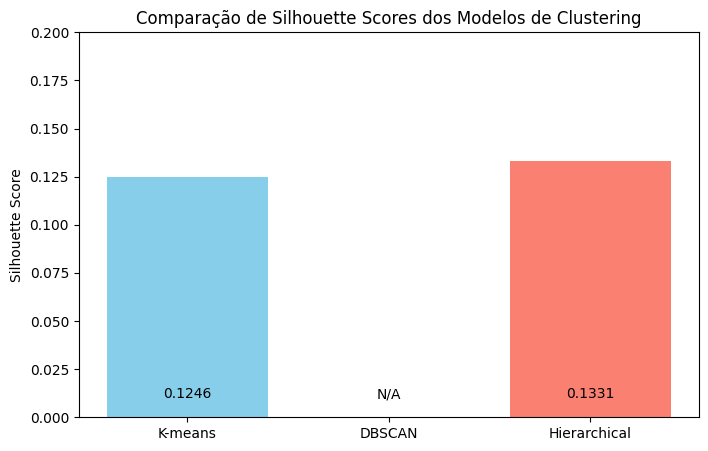

In [18]:
# Corrigindo o gráfico para gerenciar 'N/A' para DBSCAN corretamente
fig, ax = plt.subplots(figsize=(8, 5))
scores = [kmeans_silhouette, 0, hierarchical_silhouette]  # Usando 0 para DBSCAN como placeholder
models = ["K-means", "DBSCAN", "Hierarchical"]


ax.bar(models, scores, color=['skyblue', 'lightgreen', 'salmon'])
ax.set_title('Comparação de Silhouette Scores dos Modelos de Clustering')
ax.set_ylabel('Silhouette Score')
ax.set_ylim(0, 0.2)  # Limite do eixo Y considerando os scores obtidos

# Adicionando os valores dos scores no gráfico, tratando o 'N/A' manualmente
for i, v in enumerate(scores):
    score_text = 'N/A' if i == 1 else f"{v:.4f}"
    ax.text(i, 0.01, score_text, color='black', ha='center')

plt.show()
